In [67]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from IPython.display import display
import os
import pandas as pd


In [68]:
# 加载数据集
data_path = os.path.join("PEMS03_num31.npz")
data = np.load(data_path)['data']

In [69]:
# 数据预处理
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1))
imp = SimpleImputer(missing_values=0, strategy='mean')
imp.fit(data_normalized)
data_normalized = imp.transform(data_normalized).reshape(-1)

In [70]:
# 使用滑动窗口创建训练集、验证集和测试集
train_size = int(len(data_normalized) * 0.7)
valid_size = int(len(data_normalized) * 0.2)
test_size = len(data_normalized) - train_size - valid_size

train_data = data_normalized[:train_size]
valid_data = data_normalized[train_size:train_size+valid_size]
test_data = data_normalized[train_size+valid_size:]

In [71]:
periodic = [12, 288]
k_range = 10

fits = [{
        k: sm.tsa.UnobservedComponents(
            train_data,
            level=True, trend=True,
            #cycle=True,
            freq_seasonal=[{'period':q,'harmonics':[1,k][p==q] } for q in periodic]
            ).fit()
        for k in range(1, k_range+1)
    }
    for p in periodic
]

c:\Users\1213123\Documents\Scripts\CIVL7018\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\1213123\Documents\Scripts\CIVL7018\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\1213123\Documents\Scripts\CIVL7018\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\1213123\Documents\Scripts\CIVL7018\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [72]:
def mse_test_data (data):
    return ((data-test_data)**2).mean(axis=None)

def mae_test_data (data):
    return (np.absolute(data-test_data)).mean(axis=None)

def rsquared_test_data (data):
    return r2_score(test_data, data)

def iterating_k(i, models):
    index = pd.DataFrame(range(1,k_range+1), columns=['k'])
    data = [fit.get_forecast(valid_size+test_size).predicted_mean[valid_size:] for _,fit in models.items()]
    index['mse'] = [mse_test_data(d) for d in data]
    index['mae'] = [mae_test_data(d) for d in data]
    index['rsquared'] = [rsquared_test_data(d) for d in data]
    display(f"periodicity = {periodic[i]}")
    display(index)
    return index

iter_k_fits = [iterating_k(i, f) for i,f in enumerate(fits)]

'periodicity = 12'

,k,mse,mae,rsquared
0,1,0.015978,0.094973,0.773105
1,2,0.015501,0.094228,0.779890
2,3,0.015518,0.094234,0.779639
3,4,0.015529,0.094245,0.779493
4,5,0.015565,0.094263,0.778970
5,6,0.015538,0.094242,0.779354
6,7,0.015539,0.094242,0.779350
7,8,0.015537,0.094241,0.779371
8,9,0.015542,0.094245,0.779301
9,10,0.015541,0.094244,0.779318


'periodicity = 288'

,k,mse,mae,rsquared
0,1,0.015978,0.094973,0.773105
1,2,0.011573,0.075569,0.835657
2,3,0.015277,0.091758,0.783063
3,4,0.017957,0.097383,0.745016
4,5,0.017412,0.095127,0.752742
5,6,0.017085,0.091037,0.757390
6,7,0.017364,0.091878,0.753425
7,8,0.018745,0.094727,0.733824
8,9,0.018780,0.094924,0.733320
9,10,0.018852,0.095268,0.732293


C:\Users\1213123\AppData\Local\Temp\ipykernel_5440\827810264.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


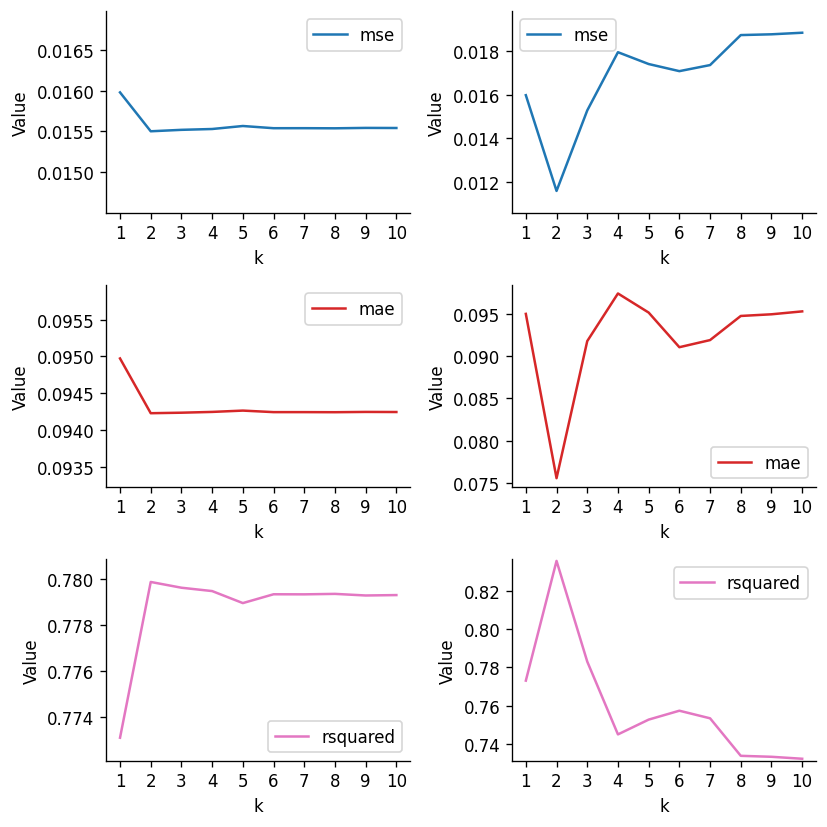

In [73]:
fig, axs = plt.subplots(3, 2, figsize=(7,7), sharex=False, sharey=False, dpi=120)
# plot mse, mae, rsquared of k
props = ['mse','mae','rsquared']
cmap = cm.get_cmap('tab10')

for i, p in enumerate(periodic):
    for j,p in enumerate(props):
        ax = axs[j,i]
        plot_data = iter_k_fits[i][p]
        ax.plot(np.arange(1, k_range+1, 1.0),plot_data, color = cmap(j/3), label=p)
        ax.set_xticks(np.arange(1, k_range+1, 1.0))
        ax.set_ylim(plot_data.min()-0.001,plot_data.max()+0.001)
        ax.legend()
        ax.set_xlabel("k")
        ax.set_ylabel("Value")

plt.tight_layout()


plt.show()

In [74]:
# Obtains best k value base on the r squared performance
ks = [f[f.rsquared == f.rsquared.max()]['k'].values[0] for f in iter_k_fits]

best_fit = sm.tsa.UnobservedComponents(
        train_data,
        level=True, trend=True,
        #cycle=True,
        freq_seasonal=[{'period':p,'harmonics':k} for p,k in zip(periodic, ks)]
        ).fit()

best_fit_forecast = best_fit.get_forecast(valid_size+test_size).predicted_mean[valid_size:]
rmse = math.sqrt(mse_test_data(best_fit_forecast))
mae = mae_test_data(best_fit_forecast)
r_squared = rsquared_test_data(best_fit_forecast)

print(*[rmse,mae,r_squared], sep=',')

0.10603218642700016,0.07415025129412875,0.8403508101049093


                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                 6048
Model:                                           None   Log Likelihood               13724.625
                    + stochastic freq_seasonal(12(2))   AIC                         -27445.250
                   + stochastic freq_seasonal(288(2))   BIC                         -27431.838
Date:                                Sun, 28 Apr 2024   HQIC                        -27440.594
Time:                                        23:02:12                                         
Sample:                                             0                                         
                                               - 6048                                         
Covariance Type:                                  opg                                         
                                  coef    std err 

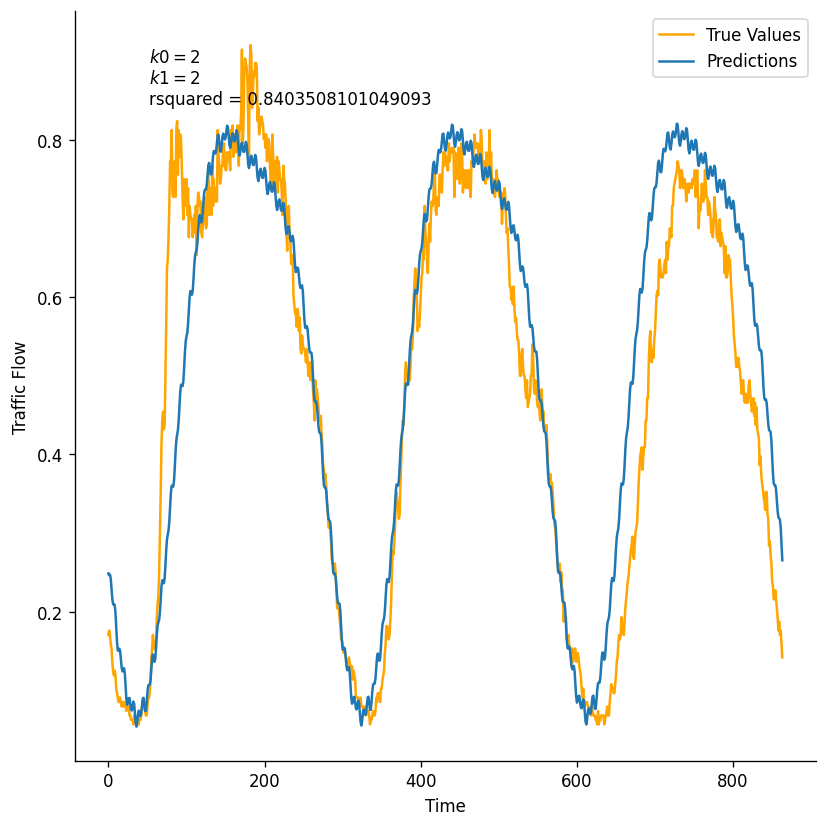

In [76]:
def show1plot():
    fig, ax = plt.subplots(1, 1, figsize=(7,7), sharex=True, sharey=True, dpi=120)

    # forecast
    ax.plot(test_data, 'orange', label='True Values')
    fc = best_fit.get_forecast(test_size)
    ax.plot(fc.predicted_mean, label='Predictions')

    ax.legend()
    plt.xlabel("Time")
    plt.ylabel("Traffic Flow")
    
    ks_text = '\n'.join([f'$k{i}={k}$' for i, k in enumerate(ks)])
    ax.text(.1, .95, f'{ks_text}\nrsquared = {r_squared}', va='top', transform=ax.transAxes)
    plt.tight_layout()

show1plot()
print(best_fit.summary())

plt.show()